# Visualization of the Data

In [8]:
import os
from multiprocessing import Pool

import pandas as pd
import numpy as np
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

ANNOTATED_FILEPATH = os.path.join(os.sep, 'home', 'data', 'ANNOTATED_BEDTIME_TU7.hdf5')

## Load the 445 subjects of which we have annotation

In [9]:
with h5py.File(ANNOTATED_FILEPATH, 'r') as hdf5_file:
    subjects = list(hdf5_file.keys())
    n_subjects = len(subjects)

In [10]:
ANNOTATED_SMALL_FILEPATH = os.path.join(os.sep, 'home', 'data', 'ANNOTATED_BEDTIME_TU7_SMALL.hdf5')

for subject in subjects[:10]:
    tmp = pd.read_hdf(ANNOTATED_FILEPATH, key=subject)
    tmp.to_hdf(ANNOTATED_SMALL_FILEPATH, key=subject)

## Show time in and out of bed over time

### Calculate the overview of the data

In [3]:
def process_subject(subject):
    tmp = pd.read_hdf(ANNOTATED_FILEPATH, key=subject)
    
    res = np.full(3600*48, -1.)

    idx = tmp.loc[:, "Time"] - np.array(tmp.loc[0,"Time"], dtype="datetime64[D]")
    
    if tmp.loc[0,"Time"] == tmp.loc[0,"Time"].normalize():
        idx += np.timedelta64(1, 'D')    
    
    res[idx.astype(int)//1e9] = 1
    
    res[idx[tmp["Annotated Time in Bed"]].astype(int)//1e9] = 2
    
    return pd.DataFrame({subject: res})

with Pool(200) as p:
    data_overview = pd.concat(p.map(process_subject, subjects), axis=1, ignore_index=True)

### Plot an overview over 45 subjects (10% of the data)

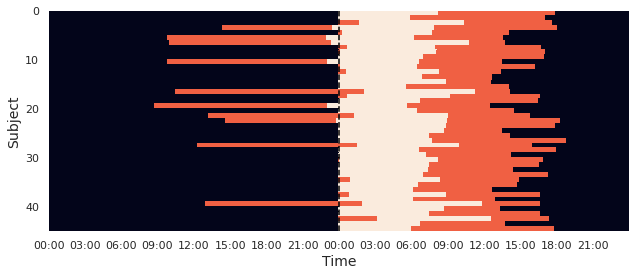

In [4]:
plt.figure(figsize=(9,4))

ax = sns.heatmap(data_overview.values[::60,100:145].T, cmap="YlGnBu", cbar=False)

ax.axvline(60*24, zorder=3, ls="--", c="black")

ax.set_xlabel('Time', size=14)   
ax.set_ylabel('Subject', size=14)   

n_hours = 48
step_size = 3
ticks, labels = zip(*[(ii * 60 * step_size, "{:02d}:00".format((ii * step_size) % 24)) for ii in range(n_hours // step_size)])

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)

ax.set_yticks(np.arange(45, step=10))
ax.set_yticklabels(np.arange(45, step=10), rotation=0)

plt.tight_layout()

## Show data preprocessing

In [5]:
subject = subjects[5]

data = pd.read_hdf(ANNOTATED_FILEPATH, key=subject)
width = 9

sig = data.set_index("Time")[["X","Y","Z"]].resample("1min").mean()
labels = data.set_index("Time")["Annotated Time in Bed"].resample("1min").pad().values
time = np.arange(sig.shape[0])

times = pd.date_range(data.reset_index().loc[0,"Time"], periods=data.shape[0], freq='1min') 
x_ticks = np.arange(sig.shape[0], step=120)
x_labels = times[x_ticks].strftime('%H:%M') 

minmax = max(abs(sig.min().min()), abs(sig.max().max())) * 1.5

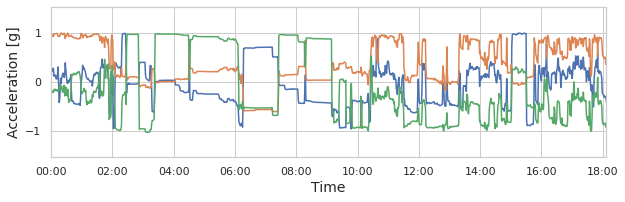

In [6]:
fig = plt.figure(figsize=(width, width/3)) 
ax = plt.subplot(1, 1, 1) 

ax.plot(time, sig)
plt.axis((0, time[-1], -minmax, minmax))
plt.xlabel('Time', size=14)
plt.ylabel('Acceleration [g]', size=14)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

plt.tight_layout()

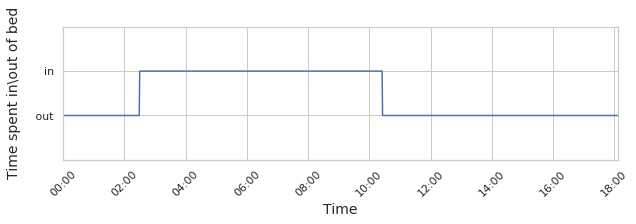

In [7]:
fig = plt.figure(figsize=(width, width/3))
ax = plt.subplot(1, 1, 1)

plt.axis((0, time[-1], -1, 2))
ax.plot(time, labels)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

ax.set_yticks([0, 1])
ax.set_yticklabels(["   out", "    in"])

plt.xlabel('Time', size=14)
plt.ylabel('Time spent in\out of bed', size=14)

plt.tight_layout()